In [1]:
import gym

from agents.dqn import DQNAgent
from utils.screen import SpaceInvaderScreen
from utils.data_loader import AtariGrandChallengeDataset
from train.solver import Solver

from torch import optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray
import numpy as np

%reload_ext autoreload
%autoreload 2

%matplotlib inline

[2018-01-20 15:58:03,532] Making new env: SpaceInvaders-v0


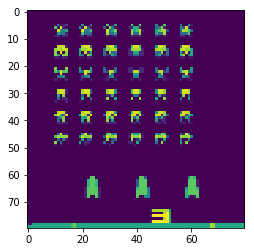

In [2]:
screen = SpaceInvaderScreen()
frame = screen.reset()
plt.imshow(frame);

In [3]:
data_dir = '/mnt/e/data/atari_v2_release'
dataset = AtariGrandChallengeDataset(data_dir, 'spaceinvaders', history_len=10, screen=screen, max_files=10)
data_train, data_valid, data_test = dataset.split(0.7, 0.2)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/e/data/atari_v2_release/trajectories/spaceinvaders'

In [4]:
agent = DQNAgent(screen, mem_size=1000)
agent.initialize(800)

Action: LEFT
Predicted: LEFTFIRE


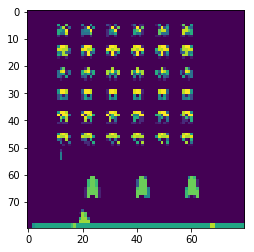

In [5]:
transition = data_train.raw(146) # get as Transition
observation = screen.output(transition.observation)
plt.imshow(observation)
print("Action:", screen.get_action_meaning(transition.action))
print("Predicted:", screen.get_action_meaning(agent.next_action(observation)))

In [5]:
batchsize = 100

train_loader = DataLoader(data_train, batch_size=batchsize, num_workers=4)
val_loader = DataLoader(data_valid, batch_size=batchsize, num_workers=4)

In [7]:
solver = Solver(optim.Adam, CrossEntropyLoss(), batchsize=batchsize, log_level='INFO')

In [ ]:
solver.train_offline(agent, train_loader, val_loader, num_epochs=1)

In [9]:
tloss = [float(loss) for loss in solver.train_loss_history]
vloss = [float(loss) for loss in solver.val_loss_history]

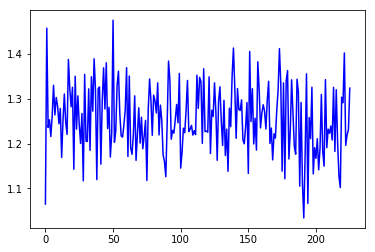

In [10]:
plt.plot(range(len(tloss)), tloss, 'b', range(len(vloss)), vloss, 'g')

In [8]:
solver.train_online(agent, screen)

[2018-01-15 17:11:30,390] Online Training started
[2018-01-15 17:11:49,595] Online Training finished


odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'conv2.weight', 'conv2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'conv3.weight', 'conv3.bias', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias'])


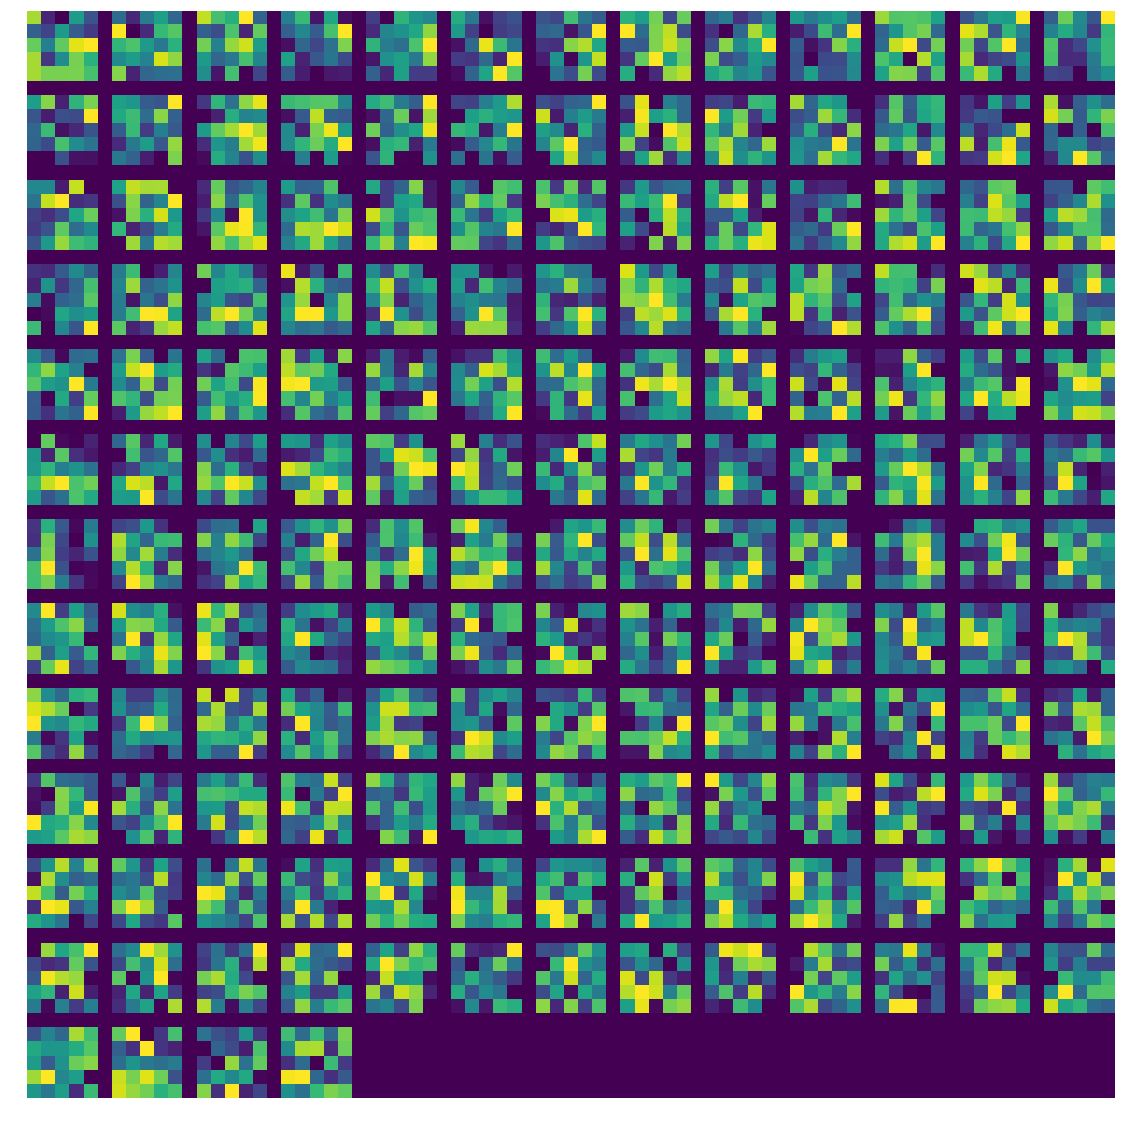

In [12]:
# Visualize weights
from math import sqrt, ceil
import numpy as np
import matplotlib.pyplot as plt

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.
  
    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    # determine grid size
    (N, C, H, W) = Xs.shape # 4D shape
    Xs = Xs.reshape(N*C, H, W) # reshape to 3D
    (N, H, W) = Xs.shape # eD shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid


print(agent.model.state_dict().keys())
#print(agent.model.state_dict()['conv1.weight'])

# Show ConvNet weights
def show_net_weights(net):
    fig = plt.figure(figsize=(20,20))
    cnn_weight1 = agent.model.state_dict()['conv1.weight'].numpy()
    
    print(cnn_weight1[0, 0, :, :].shape)
    plt.imshow(cnn_weight1[0, 0, :, :])
    plt.gca().axis('off')
    plt.show()
    
def show_net_weights2(net):
    fig = plt.figure(figsize=(20,20))
    cnn_weight1 = net.state_dict()['conv1.weight'].numpy()
    
    plt.imshow(visualize_grid(cnn_weight1))
    plt.gca().axis('off')
    plt.show()
    fig.savefig('cnn1_weights.pdf')
    
    
show_net_weights2(agent.model)

In [ ]:
solver.play(agent, screen, 20)

[2018-01-15 16:23:52,797] Wanna play a game? - Game started!
